In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation



train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
id_period_mapping = pd.read_csv("./data/id_period_mapping.csv")
test_data["period"] = id_period_mapping["period"]
sample_submission = pd.read_csv("./data/sample_submit.csv", header=None)
test_data.index = test_data["data_id"]

mask = (train_data["period"] == "train9") | (train_data["period"] == "train6") | (train_data["period"] == "train4") | (train_data["period"] == "train7") | \
(train_data["period"] == "train5") | (train_data["period"] == "train3") | (train_data["period"] == "train1") | (train_data["period"] == "train14") | \
(train_data["period"] == "train13") | (train_data["period"] == "train11") | (train_data["period"] == "train10") | (train_data["period"] == "train2") | \
(train_data["period"] == "train12") | (train_data["period"] == "train10") | (train_data["period"] == "train14")
train_data = train_data[mask]

train_y = train_data.iloc[:, -1]

l = [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]
dfx = pd.DataFrame()
for i in l:
    dfi = train_data[train_data.period == "train{}".format(i)].iloc[:, 2:90]
    dfx = dfx.append((dfi - dfi.mean()) / dfi.std())
train_X = dfx
dfx = pd.DataFrame()
for i in range(1, 11):
    dfi = test_data[test_data.period == "test{}".format(i)].iloc[:, 1:-1]
    dfx = dfx.append((dfi - dfi.mean()) / dfi.std())
test_X = dfx
test_X = test_X.loc[test_data.index]

Using TensorFlow backend.


In [2]:
concat_train_X = pd.concat([train_X, test_X])


# concat_train_X = concat_train_X.drop([u'c5', u'c6', u'c7', u'c8', u'c10', u'c13', u'c17', u'c18', u'c19',
#        u'c23', u'c28', u'c32', u'c34', u'c37', u'c41', u'c42', u'c45', u'c46',
#        u'c52', u'c54', u'c55', u'c58', u'c60', u'c62', u'c63', u'c65', u'c70',
#        u'c75', u'c82', u'c84', u'c85', u'c86', #欠損値
#        u'c38', u'c49', u'c69', u'c29', u'c79', u'c83', u'c77', u'c1', u'c51', #追加 → 10にしたら悪くなる
#        u'c72', u'c73', u'c64', u'c9', u'c78', u'c16', u'c30', u'c71', u'c83',
#        u'c45', u'c65', u'c50', u'c87', u'c64'], axis=1)

#concat_train_X = concat_train_X[["c12", "c80", "c48", "c81"]] # 0.69218 → 0.69208

concat_train_X = concat_train_X[["c12", "c80", "c48", "c81",
                                 "c68", "c56", "c27", "c67", "c20", "c4"]] # 0.69391

concat_train_X = np.array(concat_train_X)

単一モデルの場合

In [ ]:
model = Sequential()
model.add(Dense(1024, input_dim=concat_train_X.shape[1]))
model.add(Activation('relu'))
model.add(Dense(4))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(concat_train_X.shape[1]))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
model.fit(concat_train_X, concat_train_X, nb_epoch=3, batch_size=32)

In [ ]:
# with a Sequential model
get_2nd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_2nd_layer_output([concat_train_X])[0]

train_feature = layer_output[:520000, :]
test_feature = layer_output[520000:, :]

train_y = np.array(train_y)
bias = np.ones(520000)
train_feature = np.c_[train_feature, bias]
bias = np.ones(361500)
test_feature = np.c_[test_feature, bias]

アンサンブルする場合

In [4]:
pred_list = []
for i in range(5):
    model = Sequential()
    model.add(Dense(1024, input_dim=concat_train_X.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('relu'))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(concat_train_X.shape[1]))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    model.fit(concat_train_X, concat_train_X, nb_epoch=5, batch_size=128)
    
    # with a Sequential model
    get_2nd_layer_output = K.function([model.layers[0].input],
                                      [model.layers[2].output])
    layer_output = get_2nd_layer_output([concat_train_X])[0]

    train_feature = layer_output[:520000, :]
    test_feature = layer_output[520000:, :]

    train_y = np.array(train_y)
    bias = np.ones(520000)
    train_feature = np.c_[train_feature, bias]
    bias = np.ones(361500)
    test_feature = np.c_[test_feature, bias]
    
    w = np.linalg.inv(train_feature.T.dot(train_feature)).dot(train_feature.T).dot(train_y)
    pred = w.dot(test_feature.T)
    pred_list.append(pred)

Epoch 1/5
881500/881500 [==============================] - 49s - loss: 0.4400 - acc: 0.4622    
Epoch 2/5
881500/881500 [==============================] - 49s - loss: 0.3871 - acc: 0.4915    - ETA: 0s - loss: 0.3870 - acc: 0.49 - ETA: 0s - lo - ETA: 0s - loss: 0.3871 - 
Epoch 3/5
881500/881500 [==============================] - 49s - loss: 0.3709 - acc: 0.5059    - ETA: 0s - loss: - ETA: 0s - loss: 0 - ETA: 0s - loss: 0.37
Epoch 4/5
881500/881500 [==============================] - 49s - loss: 0.3632 - acc: 0.5156    - ETA: 0s - loss: 0.3632 - a
Epoch 5/5
881500/881500 [==============================] - 49s - loss: 0.3562 - acc: 0.5224    
Epoch 1/5
881500/881500 [==============================] - 49s - loss: 0.4437 - acc: 0.4157    
Epoch 2/5
881500/881500 [==============================] - 48s - loss: 0.3900 - acc: 0.4553    - ETA: 0s - loss: 0.3900
Epoch 3/5
881500/881500 [==============================] - 47s - loss: 0.3741 - acc: 0.4731    
Epoch 4/5
881500/881500 [================

In [5]:
sample_submission[1] = np.average(pred_list, 0)

線形回帰

In [133]:
w = np.linalg.inv(train_feature.T.dot(train_feature)).dot(train_feature.T).dot(train_y)
sample_submission[1] = w.dot(test_feature.T)

In [139]:
sample_submission[1][sample_submission[1] < 0.1] = 0.1

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 結果確認

In [6]:
sample_submission.to_csv("result2.csv", index=0)

In [7]:
sample_submission.iloc[:, 1].mean()

0.49997308017645903

In [8]:
sample_submission[1].max()

0.56558181614183145

In [9]:
sample_submission[1].min()

0.23333341676661412

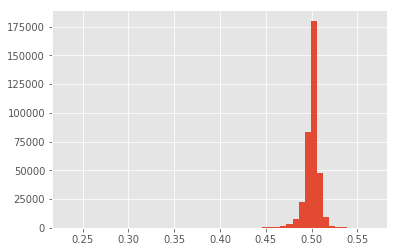

In [10]:
plt.style.use("ggplot")
plt.hist(sample_submission[1], bins=50)
plt.show()

- アンサンブルもしたい